In [1]:
import s3fs
import datetime
import xarray as xr
import numpy as np

import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.colors as mcolors

from cartopy import crs as ccrs
import cartopy.feature as cfeature

from pathlib import Path
from PIL import Image
import os

In [2]:
fs = s3fs.S3FileSystem(anon=True)

In [3]:
products = fs.ls('noaa-goes16')

Set the date and hour for the data of interest: 

In [4]:
year = 2023
month = 3
day = 31
hour = 23

julian_day = datetime.datetime(year, month, day).strftime('%j')
print(julian_day)

090


Product chosen: ABI imager (mesoscale)

In [5]:
bucket = 'noaa-goes16'
product = 'ABI-L1b-RadM'

data_path = bucket + '/' + product + '/'  + str(year) + '/' + julian_day + '/' + str(hour).zfill(2)

files = fs.ls(data_path)

#for file in files:
#    print(file.split('/')[-1])

M1 refers to mesoscale sector 1, M6 refers to scan mode 6.

Select the start and end times within the hour selected earlier: 

In [6]:
observation_start = '2330'
observation_end = '2400'
product_name = 'ABI-L1b-RadM1-M6C01' #blue vis band

matches = [file for file in files if (file.split('/')[-1].split('_')[3][8:12] >= observation_start and file.split('/')[-1].split('_')[3][8:12] <= observation_end and file.split('/')[-1].split('_')[1] == product_name)]

for match in matches:
    print(match.split('/')[-1])
    print('Approximate file size (MB):', round((fs.size(match)/1.0E6), 2))

OR_ABI-L1b-RadM1-M6C01_G16_s20230902330276_e20230902330336_c20230902330375.nc
Approximate file size (MB): 0.9
OR_ABI-L1b-RadM1-M6C01_G16_s20230902331247_e20230902331307_c20230902331343.nc
Approximate file size (MB): 0.9
OR_ABI-L1b-RadM1-M6C01_G16_s20230902332247_e20230902332307_c20230902332344.nc
Approximate file size (MB): 0.89
OR_ABI-L1b-RadM1-M6C01_G16_s20230902333247_e20230902333306_c20230902333347.nc
Approximate file size (MB): 0.88
OR_ABI-L1b-RadM1-M6C01_G16_s20230902334247_e20230902334306_c20230902334355.nc
Approximate file size (MB): 0.87
OR_ABI-L1b-RadM1-M6C01_G16_s20230902335247_e20230902335307_c20230902335341.nc
Approximate file size (MB): 0.87
OR_ABI-L1b-RadM1-M6C01_G16_s20230902336247_e20230902336307_c20230902336349.nc
Approximate file size (MB): 0.86
OR_ABI-L1b-RadM1-M6C01_G16_s20230902337247_e20230902337309_c20230902337351.nc
Approximate file size (MB): 0.85
OR_ABI-L1b-RadM1-M6C01_G16_s20230902338247_e20230902338311_c20230902338356.nc
Approximate file size (MB): 0.84
OR_

Function to get latitude and longitude from goes fixed grid:

In [7]:
def calculate_abi_lat_lon(ds):
    
    # Read in GOES ABI fixed grid projection variables and constants
    x_coordinate_1d = ds.x  # E/W scanning angle in radians
    y_coordinate_1d = ds.y  # N/S elevation angle in radians
    projection_info = ds.goes_imager_projection  # ABI fixed grid contstants
    lon_origin = projection_info.longitude_of_projection_origin
    H = projection_info.perspective_point_height+projection_info.semi_major_axis
    r_eq = projection_info.semi_major_axis
    r_pol = projection_info.semi_minor_axis
    
    # Create 2D coordinate matrices from 1D coordinate vectors
    x_coordinate_2d, y_coordinate_2d = np.meshgrid(x_coordinate_1d, y_coordinate_1d)
    
    # Equations to calculate latitude and longitude
    lambda_0 = (lon_origin*np.pi)/180.0  
    a_var = np.power(np.sin(x_coordinate_2d),2.0) + (np.power(np.cos(x_coordinate_2d),2.0)*(np.power(np.cos(y_coordinate_2d),2.0)+(((r_eq*r_eq)/(r_pol*r_pol))*np.power(np.sin(y_coordinate_2d),2.0))))
    b_var = -2.0*H*np.cos(x_coordinate_2d)*np.cos(y_coordinate_2d)
    c_var = (H**2.0)-(r_eq**2.0)
    r_s = (-1.0*b_var - np.sqrt((b_var**2)-(4.0*a_var*c_var)))/(2.0*a_var)
    s_x = r_s*np.cos(x_coordinate_2d)*np.cos(y_coordinate_2d)
    s_y = - r_s*np.sin(x_coordinate_2d)
    s_z = r_s*np.cos(x_coordinate_2d)*np.sin(y_coordinate_2d)
    
    lat = (180.0/np.pi)*(np.arctan(((r_eq*r_eq)/(r_pol*r_pol))*((s_z/np.sqrt(((H-s_x)*(H-s_x))+(s_y*s_y))))))
    lon = (lambda_0 - np.arctan(s_y/(H-s_x)))*(180.0/np.pi)
    
    return lat, lon

Checking out the mesoscale sector:

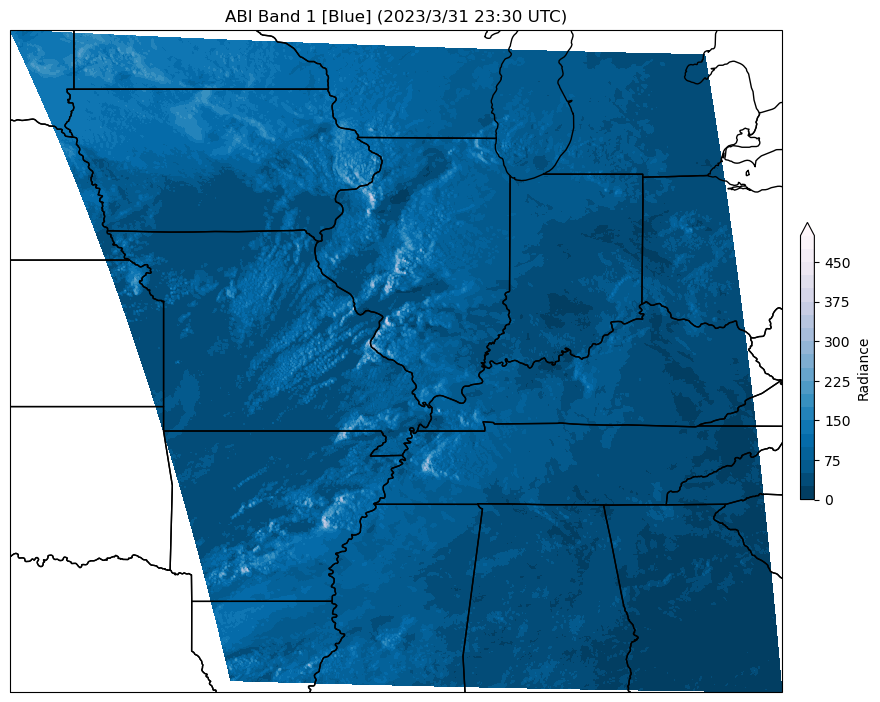

In [8]:
with fs.open(matches[0], mode='rb') as remote_file:
    with xr.open_dataset(remote_file, engine='h5netcdf') as ds:
        projection=ccrs.PlateCarree()
        fig,ax=plt.subplots(1, figsize=(12,12),subplot_kw={'projection': projection})
        cmap = plt.cm.PuBu_r
        levels = np.linspace(0, 500, 21)

        lat, lon = calculate_abi_lat_lon(ds)
        ax.set_extent([np.nanmin(lon), np.nanmax(lon), np.nanmin(lat), np.nanmax(lat)])
        #ax.set_extent([-67, -125, 25, 49]) --- CONUS

        c=ax.contourf(lon, lat, ds.Rad, cmap=cmap, extend='max', levels=levels)
        clb=plt.colorbar(c, shrink=0.3, pad=0.02, ax=ax)
        clb.set_label('Radiance')

        ax.coastlines(resolution='50m', color='black', linewidth=1)
        ax.add_feature(cfeature.STATES)

        time = matches[0].split('/')[-1][35:37] +':'+ matches[0].split('/')[-1][37:39]
        date = str(year) +'/'+ str(month) +'/'+ str(day)
        title = 'ABI Band 1 [Blue] (' + date + ' ' + time + ' UTC)'
        ax.set_title(title)

Creating the images for the animation: 

In [9]:
image_dir = 'ABI_Band1_'+str(year)+'_'+str(month)+'_'+str(day)

if not os.path.exists(image_dir):
    os.makedirs(image_dir)

In [10]:
for match in matches:
    with fs.open(match, mode='rb') as remote_file:
        with xr.open_dataset(remote_file, engine='h5netcdf') as ds:
            projection=ccrs.PlateCarree()
            fig,ax=plt.subplots(1, figsize=(12,12),subplot_kw={'projection': projection})
            cmap = plt.cm.PuBu_r
            levels = np.linspace(0, 500, 21)

            lat, lon = calculate_abi_lat_lon(ds)
            ax.set_extent([np.nanmin(lon), np.nanmax(lon), np.nanmin(lat), np.nanmax(lat)])
            #ax.set_extent([-67, -125, 25, 49]) --- CONUS

            c=ax.contourf(lon, lat, ds.Rad, cmap=cmap, extend='max', levels=levels)
            clb=plt.colorbar(c, shrink=0.3, pad=0.02, ax=ax)
            clb.set_label('Radiance')

            ax.coastlines(resolution='50m', color='black', linewidth=1)
            ax.add_feature(cfeature.STATES)
            
            time = match.split('/')[-1][35:37] +':'+ match.split('/')[-1][37:39]
            date = str(year) +'/'+ str(month) +'/'+ str(day)
            title = 'ABI Band 1 [Blue] (' + date + ' ' + time + ' UTC)'
            ax.set_title(title)
            
            saved_file_name = 'ABI_Band1_'+str(year)+'_'+str(month)+'_'+str(day)+'_'+match.split('/')[-1][35:39]
            fig.savefig(image_dir+'/'+saved_file_name, dpi=100, bbox_inches='tight')
            
            plt.close()

In [11]:
def create_pillow_animation(file_list, save_path, save_name, duration, loop):
    frames = [Image.open(file) for file in file_list]

    frames[0].save((save_path / save_name).as_posix() + '.gif', format='GIF', append_images=frames[1:], 
                    save_all=True, duration=duration, loop=loop)
    print('Animation done!')

In [12]:
pil_duration = 100  # Time in ms between frames (e.g., 1000 ms = 1 second between frames)
pil_loop = 0  # No. times animation repeats (e.g., 0: loops continuously; 2: runs 3 times then stops)
animation_save_path = Path.cwd()  # Directory where animation file will be saved
date = str(year)+'_'+str(month)+'_'+str(day)
animation_save_name = 'ABI_Band1_'+date+'_animation'  # Name for saved animation .gif file

graphics_files = sorted(Path.cwd().glob(image_dir+'/ABI_Band1_'+date+'*.png'))

# Create the animation using the function defined previously
create_pillow_animation(graphics_files, animation_save_path, animation_save_name, pil_duration, pil_loop)

Animation done!
